# Hash de imágenes

El problema consiste en detectar imágenes iguales en dos colecciones. 

Pero así dicho es un problema mal planteado. La igualdad es una relación de equivalencia 
y tenemos que precisar qué se entiende por imágenes iguales:

* son el mismo archivo en otro directorio?
  > tienen el mismo nombre, las mismas fechas de creación y modificación, usuario y grupo propietario...  
* los archivos tienen el mismo contenido?
  > los bits que contienen son exactamente los mismos.
* las imágenes que contienen son exactamente iguales?
  > si se alteraron los metadatos no afecta la comparación.
* las imágenes se ven iguales?
  > las imágenes son las mismas ante transformaciones de resolución, rotación, cambio de gamma, contraste...

Dependiendo del nivel que interesa trabajar, tenemos diferentes herramientas y diferentes tiempos de cálculo. 

Este notebook está para ver cómo se implementa cada una de ellas y cuánto tarda cada rutina. 

## 1. Funciones de Benchmark

Necesitamos alguna herramienta para evaluar el tiempo de ejecución.    
Vamos a hacerlo con el comando mágico `timeit`:
* `%timeit -n<N> -r<R> (statement)`
* ```
  %%timeit -n<N> -r<R>
  (cell) 
  ```

Donde `N` es el número de loops y `r` las repeticiones por loop.

## 2. Estrategias de comparación

### 2.1 Datos del sistema operativo

Hay propiedades de los archivos que guarda el sistema operativo.    
Las más comunes son: `filename/owner/group/times(access/modification/creation)`

El problema con esto es que muchas de ellas dependen del sistema operativo en que están alojados los archivos. 

La biblioteca [`pathlib`](https://docs.python.org/3/library/pathlib.html) hace un formidable esfuerzo por obtener información intependientemente del sistema. En particular el método [`Path.stat`](https://docs.python.org/3/library/os.html#os.stat_result) ofrece la mejor herramienta, pero hay que tener cuidado porque muchas propiedades son dependientes del sistema operativo y probablemente se arruinen al pasar los archivos de un sistema a otro. 

Este es un problema con el que no me interesa trabajar, porque los sistemas operativos son un monstruo grande y la gente hace cosas medio raras con ellos. 

### 2.2 Contenido de los archivos

Para analizar el contenido completo de un archivo, podemos utilizar funciones criptográficas (hash) o números que se usan para verificar la integridad de los datos en comunicaciones (CRC).

Si los archivos son idénticos, los números deberían coincidir exactamente. 

Pero si los archivos difieren, la idea de las funciones criptográficas es que el resultado sea completamente diferente aunque cambie un sólo bit de información. Sirven para verificar la identidad exacta o no de la información del archivo. 

Vamos a implementar tres funciones de Python que utilizan los métodos: 
* `md5`
* `sha256`
* `crc16.arc`

In [2]:
import hashlib
from fastcrc import crc16

def md5_file(fname):
    with open(fname,'rb') as f:
        return hashlib.md5(f.read()).hexdigest()
    
def sha_file(fname):
    with open(fname,'rb') as f:
        return hashlib.sha256(f.read()).hexdigest()
    
def crc_file(fname):
    with open(fname,'rb') as f:
        return crc16.arc(f.read())

In [3]:
fname = "DSCN3928.JPG"
fpath = f"coleccion/{fname}"

print("\nmd5")
%timeit -n100 -r1 md5_file(fpath)
print(md5_file(fpath))
print("\nsha256")
%timeit -n100 -r1 sha_file(fpath)
print(sha_file(fpath))
print("\ncrc")
%timeit -n100 -r1 crc_file(fpath)
print(crc_file(fpath))


md5
3.54 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
7eec7ace7076758c6f5f497325b15fc3

sha256
1.87 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
83a6500810091fc0f1f357baa6e11417d7cbc7f701457fd4943eb769cb07a7f9

crc
5.08 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
7251


Vemos que sha256 es el método más rápido además la mejor función criptográfica. 

En algunos lugares recomiendan paginar la entrada si el archivo es muy largo para no llenar la RAM. [referencia de StackOverflow](https://stackoverflow.com/questions/22058048/hashing-a-file-in-python)

### 2.3 Contenido exacto de las imágenes

Podemos leer los archivos, exceptuando toda la metadata que contienen.    
Las implementaciones disponibles utilizan todas la biblioteca PIL para cargar la imagen.    
A continuación la leemos en binario y calculamos el hash.

In [4]:
from PIL import Image

def sha_img(fname):
    im = Image.open(fname)
    return hashlib.sha256(im.tobytes()).hexdigest()

In [5]:

print("\nsha256-image")
%timeit -n100 -r1 sha_img(fpath)
print(sha_img(fpath))


sha256-image
151 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
18348a1d5aebb512c93f7d0ed42c0477ba7c1341dc48add90361a9cbe330fb34


Tarda 100 veces más que procesando el archivo entero !!!   
Se ve que la carga en memoria del PIL es muy lenta. 

### 2.4 Contenido perceptual

Hay gente a la que le interesa identificar una imagen a partir de su contenido, y que no importe demasiado la resolución, o si tiene modificaciones pequeñas o rotaciones o cambios de brillo y gamma. 

Para eso está la biblioteca del Python [`imagehash`](https://pypi.org/project/ImageHash/) que construye hashes que describen el contenido de la imagen y que dos imágenes similares, tendrán también hashes idénticos o muy parecidos. 

Hay un [blog con la discusión de los diferentes métodos](https://tech.okcupid.com/evaluating-perceptual-image-hashes-at-okcupid-e98a3e74aa3a). De la discusión, decidimos usar sólo el método de hash perceptual `phash`.

In [6]:
import imagehash

def phash_img(fname):
    im = Image.open(fname)
    return str(imagehash.phash(im))

In [7]:
print("\npreceptual hash")
%timeit -n100 -r1 phash_img(fpath)
print(phash_img(fpath))


preceptual hash
124 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
95bd879189928cdb


Se ve que el tiempo está dominado por la carga de la imagen.    
Más adelante discutimos la selectividad. 

### 2.5 Redes neuronales

Hay una biblioteca reciente que utiliza redes neuronales para realizar este trabajo:   
> [imagededup](https://idealo.github.io/imagededup/)


La biblioteca incluye una evaluación de distancia entre imágenes y realiza la evaluación en bloque de a ramas de directorios completos. Aquí vamos a probar con sólo una imagen. 

Vamos a usar especialmente la [clase CNN](https://idealo.github.io/imagededup/methods/cnn/)

In [8]:
from imagededup.methods import CNN
CNNencoder = CNN()

def CNN_img(fname):
    #myencoder = CNN()
    return str(CNNencoder.encode_image(image_file=fname))

2023-06-19 00:01:07,707: INFO Device set to cpu ..
2023-06-19 00:01:07,710: INFO Initialized: mobilenet_v3_small for feature extraction ..


In [9]:
print("\nRedes neuronales")
%timeit -n10 -r1 CNN_img(fpath)
print()
print(CNN_img(fpath))


Redes neuronales
218 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)

[[ 1.98295135e-02  8.29459876e-02 -2.10834574e-03  2.46195734e-01
   8.32153410e-02  2.32856244e-01  2.33051151e-01  7.18513653e-02
   7.97586739e-01  4.59564328e-02  4.34547931e-01  2.27930561e-01
   1.20448485e-01  1.20432234e+00  1.22179791e-01  1.06205082e+00
   6.33122087e-01  2.63749838e-01  8.25113237e-01  5.29056564e-02
   6.12630844e-01  7.08085448e-02  2.78410912e-02  1.49956062e-01
  -9.37710404e-02  3.53346288e-01 -3.91329117e-02  3.28089952e-01
   4.27720100e-01  8.56013954e-01  2.55386621e-01  2.76195556e-01
   2.75260955e-01  1.27929002e-01  2.44832635e-01  2.81298018e+00
   2.67539918e-01  5.93662895e-02  1.73957944e-01  7.35708117e-01
   3.99977230e-02  1.14272669e-01  4.91459996e-01  1.71574891e-01
   4.81784612e-01 -1.46063671e-01  3.62546653e-01  8.22853029e-01
  -2.14655008e-02 -3.55235860e-02 -1.60908401e-02  9.85083818e-01
  -2.47551478e-04  8.96696210e-01  5.21433473e-01  2.0407

Tarda más que los métodos perceptuales, pero no llega a ser el doble de tiempo.   
La salida es complicada de leer, pero la misma biblioteca nos da herramientas para medir las distancias. 

----

# Discriminación de los hashes

(en construcción)

Vamos a proponer una colección con variaciones de una imagen, para ver cómo funcionan los diferentes hashes. 

In [14]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from glob import glob

lfiles = glob("coleccion/*")

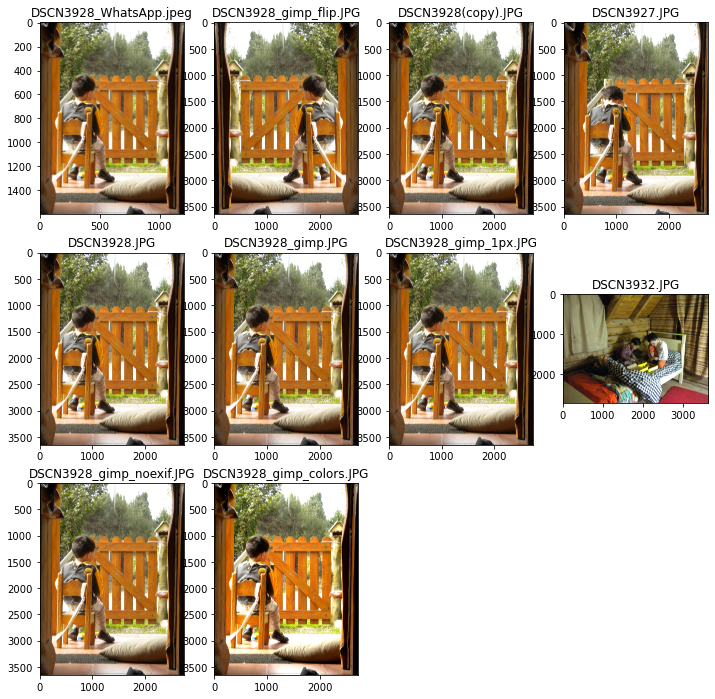

In [19]:
# graphs
ncol = 4

nfigs = len(lfiles)
nrow = nfigs // ncol
if nfigs % ncol != 0:
    nrow += 1
plt.figure(figsize=(12,12))

for i,fname in enumerate(lfiles):
    plt.subplot(nrow,ncol,i+1)
    plt.title(fname.split("/")[-1])
    img = mpimg.imread(fname)
    imgplot = plt.imshow(img)

In [20]:
hashfn = phash_img
lhashes = []
for f in lfiles:
    lhashes.append(hashfn(f))

j=1
jhashes = []
for i,f in enumerate(lfiles):
    if i==0:
        j=1
        jhashes.append(1)
    elif lhashes[i] not in lhashes[:i]:
        j+=1
        jhashes.append(j)
    else:
        jhashes.append(jhashes[lhashes.index(lhashes[i])])

    print(jhashes[-1], f.split("/")[-1])

1 DSCN3928_WhatsApp.jpeg
2 DSCN3928_gimp_flip.JPG
1 DSCN3928(copy).JPG
3 DSCN3927.JPG
1 DSCN3928.JPG
1 DSCN3928_gimp.JPG
1 DSCN3928_gimp_1px.JPG
4 DSCN3932.JPG
1 DSCN3928_gimp_noexif.JPG
5 DSCN3928_gimp_colors.JPG


In [31]:
myencoder = CNN()
duplicates = myencoder.find_duplicates(image_dir='coleccion')

2023-06-19 00:22:30,982: INFO Device set to cpu ..
2023-06-19 00:22:30,986: INFO Initialized: mobilenet_v3_small for feature extraction ..
2023-06-19 00:22:30,986: INFO Start: Image encoding generation
2023-06-19 00:22:33,024: INFO End: Image encoding generation
2023-06-19 00:22:33,025: INFO Start: Calculating cosine similarities...
2023-06-19 00:22:33,026: INFO End: Calculating cosine similarities.


In [32]:
duplicates

{'DSCN3927.JPG': ['DSCN3928(copy).JPG',
  'DSCN3928.JPG',
  'DSCN3928_WhatsApp.jpeg',
  'DSCN3928_gimp.JPG',
  'DSCN3928_gimp_1px.JPG',
  'DSCN3928_gimp_colors.JPG',
  'DSCN3928_gimp_flip.JPG',
  'DSCN3928_gimp_noexif.JPG'],
 'DSCN3928(copy).JPG': ['DSCN3927.JPG',
  'DSCN3928.JPG',
  'DSCN3928_WhatsApp.jpeg',
  'DSCN3928_gimp.JPG',
  'DSCN3928_gimp_1px.JPG',
  'DSCN3928_gimp_colors.JPG',
  'DSCN3928_gimp_flip.JPG',
  'DSCN3928_gimp_noexif.JPG'],
 'DSCN3928.JPG': ['DSCN3927.JPG',
  'DSCN3928(copy).JPG',
  'DSCN3928_WhatsApp.jpeg',
  'DSCN3928_gimp.JPG',
  'DSCN3928_gimp_1px.JPG',
  'DSCN3928_gimp_colors.JPG',
  'DSCN3928_gimp_flip.JPG',
  'DSCN3928_gimp_noexif.JPG'],
 'DSCN3928_WhatsApp.jpeg': ['DSCN3927.JPG',
  'DSCN3928(copy).JPG',
  'DSCN3928.JPG',
  'DSCN3928_gimp.JPG',
  'DSCN3928_gimp_1px.JPG',
  'DSCN3928_gimp_colors.JPG',
  'DSCN3928_gimp_flip.JPG',
  'DSCN3928_gimp_noexif.JPG'],
 'DSCN3928_gimp.JPG': ['DSCN3927.JPG',
  'DSCN3928(copy).JPG',
  'DSCN3928.JPG',
  'DSCN3928_WhatsAp

In [33]:
jhashes=[]
for i,f in enumerate(lfiles):
    if i==0:
        j=1
        jhashes.append(j)
    elif len(duplicates[f.split("/")[-1]]) == 0:
        #print("---", duplicates[f.split("/")[-1]])
        j +=1
        jhashes.append(j)
    else:
        original_file = "coleccion/"+duplicates[f.split("/")[-1]][0]
        duplicated_files = ["coleccion/"+fn for fn in duplicates[f.split("/")[-1]]]
        for ii,ff in enumerate(lfiles):
            if ff in duplicated_files:
                i0 = ii
                break
        if i0 > len(jhashes):
            j+=1
            jhashes.append(j)
        else:
            jhashes.append(jhashes[i0])
    print(jhashes[-1], f.split("/")[-1])

1 DSCN3928_WhatsApp.jpeg
1 DSCN3928_gimp_flip.JPG
1 DSCN3928(copy).JPG
1 DSCN3927.JPG
1 DSCN3928.JPG
1 DSCN3928_gimp.JPG
1 DSCN3928_gimp_1px.JPG
2 DSCN3932.JPG
1 DSCN3928_gimp_noexif.JPG
1 DSCN3928_gimp_colors.JPG


---